In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import time

from tensorflow.contrib.distributions import Normal, Gamma
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# load data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
print("train: "+str(mnist.train.num_examples))
print("test: "+str(mnist.test.num_examples))

train: 55000
test: 10000


In [4]:
# model variables
N_FEATURES = 28*28
N_HIDDEN = 512
N_CLASSES = 10
DIM_THETA = (N_FEATURES+1)*N_HIDDEN +(N_HIDDEN+1)*N_CLASSES + 1 #fc1+fc2+gamma 
ALPHA, BETA = 1., 0.1

N_TRAIN = mnist.train.num_examples
N_BATCH = 100

#stein variables
EL = 1e-3 
N_ITERATIONS = 1100
M = 5 # number of particles

#adam variables
FUDGE_FACTOR = 1e-6
AUTO_CORR = 0.9

In [5]:
#create the first model
with tf.name_scope("model"):
    # variables
    model_x = tf.placeholder(tf.float32, [None, N_FEATURES])
    model_y = tf.placeholder(tf.float32, [None, N_CLASSES]) # one-hot-encoding
    
    model_w1 = tf.Variable(tf.zeros([N_FEATURES,N_HIDDEN], dtype=tf.float32))
    model_b1 = tf.Variable(tf.zeros([N_HIDDEN], dtype=tf.float32))
    
    model_w2 = tf.Variable(tf.zeros([N_HIDDEN,N_CLASSES], dtype=tf.float32))
    model_b2 = tf.Variable(tf.zeros([N_CLASSES], dtype=tf.float32))
    
    model_log_lambda = tf.Variable(tf.zeros([]))
    model_lambda = tf.exp(model_log_lambda)

    with tf.name_scope("prediction"):
        model_fc1 = tf.nn.relu(tf.matmul(model_x, model_w1) + model_b1)
        model_prediction = tf.nn.softmax(tf.matmul(model_fc1, model_w2) + model_b2) # y = softmax(w*x+b)
    
    with tf.name_scope("likelihood"):
        log_prediction = tf.log(model_prediction) # log p(y=i|x,w), for i = 0,...,9
        #use the true label, we need for x_i log p(y=y_i|x_i,w)
        log_like = tf.reduce_sum(model_y * log_prediction, 1) 
        log_likelihood = tf.reduce_sum(log_like) #log p(D|w)
    
    with tf.name_scope("priors"):
        prior_lambda = Gamma(ALPHA, BETA)
        prior_w1 = Normal(
            tf.zeros([N_FEATURES, N_HIDDEN]),
            tf.reciprocal(tf.sqrt(model_lambda))
        )
        prior_b1 = Normal(
            tf.zeros([N_HIDDEN]),
            tf.reciprocal(tf.sqrt(model_lambda))
        )
        prior_w2 = Normal(
            tf.zeros([N_HIDDEN, N_CLASSES]),
            tf.reciprocal(tf.sqrt(model_lambda))
        )
        prior_b2 = Normal(
            tf.zeros([N_CLASSES]),
            tf.reciprocal(tf.sqrt(model_lambda))
        )
    
    log_p = (
        log_likelihood * N_TRAIN / N_BATCH +
        # Variance priors.
        prior_lambda.log_prob(model_log_lambda) +
        # Weight and bias priors.
        tf.reduce_sum(prior_w1.log_prob(model_w1)) +
        tf.reduce_sum(prior_b1.log_prob(model_b1)) +
        tf.reduce_sum(prior_w2.log_prob(model_w2)) +
        tf.reduce_sum(prior_b2.log_prob(model_b2))
    )
        
    m_grad_log_p = tf.gradients(log_p, [model_w1, model_b1, 
                                        model_w2, model_b2, 
                                        model_log_lambda])

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [6]:
def get_real_median(v):
    v = tf.reshape(v, [-1])
    l = v.get_shape()[0]
    mid = l//2 + 1
    val = tf.nn.top_k(v, mid).values
    if l % 2 == 1:
        return val[-1]
    else:
        return 0.5 * (val[-1] + val[-2])

def svgd_kernel(theta):
    # compute dist
    r = tf.reduce_sum(theta*theta, 1)
    r = tf.reshape(r, [-1, 1])
    pairwise_dists = r - 2.*tf.matmul(theta, tf.transpose(theta)) + tf.transpose(r)
    
    #using median trick and compute h
    m = get_real_median(pairwise_dists)
    h = tf.sqrt(0.5 * m / tf.log(tf.cast(theta.get_shape()[0], tf.float32)+1.0))
    
    # kernel matrix
    kernel_matrix = tf.exp(-pairwise_dists/h**2/2)
    
    # gradient of kernel matrix
    grad_kernel = -tf.matmul(kernel_matrix, theta)
    sumkxy = tf.expand_dims(tf.reduce_sum(kernel_matrix, axis=1), 1) 
    grad_kernel = tf.add(grad_kernel, tf.multiply(theta, sumkxy)) / (h ** 2)

    return kernel_matrix, grad_kernel
    
#create the inference
with tf.name_scope("inference"):
    in_theta = tf.placeholder(tf.float32, [M, DIM_THETA]) # w+b+gamma
    in_grad_log_p = tf.placeholder(tf.float32, [M, DIM_THETA])
    
    kernel_matrix, grad_kernel = svgd_kernel(in_theta)
    #grad_log_p = gradient_posterior(theta)
    in_dir_phi = (tf.matmul(kernel_matrix, in_grad_log_p) + grad_kernel)/M

In [7]:
#initialize theta 0
w1_0 = 1.0 / np.sqrt(N_FEATURES + 1) * np.random.randn(M, N_FEATURES*N_HIDDEN)
b1_0 = np.zeros((M, N_HIDDEN), dtype=np.float32)

w2_0 = 1.0 / np.sqrt(N_HIDDEN + 1) * np.random.randn(M, N_HIDDEN*N_CLASSES)
b2_0 = np.zeros((M, N_CLASSES), dtype=np.float32)

log_lambda_0 = np.log(np.random.gamma(ALPHA, BETA, (M,1)))

theta_new = np.concatenate((w1_0,b1_0,w2_0,b2_0,log_lambda_0), axis=1)

grad_log_p = np.zeros((M,DIM_THETA), dtype=np.float32)

historical_grad = 0

start_time = time.time()
with tf.Session() as sess: 
    for iter in range(N_ITERATIONS): 
        batch_x, batch_y = mnist.train.next_batch(N_BATCH) 
        
        for i, particle in enumerate(theta_new):  #TODO matrix way
            a = N_FEATURES*N_HIDDEN
            b = a + N_HIDDEN 
            
            pack_w1 = np.reshape(particle[:a], [N_FEATURES, N_HIDDEN])
            pack_b1 = particle[a:b]
            
            c = b + N_HIDDEN*N_CLASSES
            d = c + N_CLASSES 
            
            pack_w2 = np.reshape(particle[b:c], [N_HIDDEN, N_CLASSES])
            pack_b2 = particle[c:d]
            
            pack_log_lambda = particle[-1]
            
            loss, pack_grad_log_p = sess.run([log_p,m_grad_log_p], feed_dict=
                                 {model_x: batch_x,
                                  model_y: batch_y,
                                  model_w1: pack_w1,
                                  model_b1: pack_b1,
                                  model_w2: pack_w2,
                                  model_b2: pack_b2,
                                  model_log_lambda: pack_log_lambda})
            
            grad_log_p_w1 = np.reshape(pack_grad_log_p[0], [N_FEATURES*N_HIDDEN])
            grad_log_p_b1 = pack_grad_log_p[1]
            grad_log_p_w2 = np.reshape(pack_grad_log_p[2], [N_HIDDEN*N_CLASSES])
            grad_log_p_b2 = pack_grad_log_p[3]
            grad_log_p_log_lambda = np.array([pack_grad_log_p[4]])
            
            grad_log_p[i,:] = np.concatenate((grad_log_p_w1, 
                                             grad_log_p_b1,
                                             grad_log_p_w2, 
                                             grad_log_p_b2,
                                             grad_log_p_log_lambda))
            
            #print(pack_grad_log_p[2])
        
        dir_phi = sess.run(in_dir_phi, feed_dict=
                               {in_theta: theta_new, 
                                in_grad_log_p: grad_log_p})
        #print(theta_new[:,-1])
        #print(dir_phi[:,-1])
        
        # adagrad 
        if iter == 0:
            historical_grad = historical_grad + np.multiply(dir_phi, dir_phi)
        else:
            historical_grad = AUTO_CORR * historical_grad +\
            (1 - AUTO_CORR) * np.multiply(dir_phi, dir_phi)
        adj_phi = np.divide(dir_phi, FUDGE_FACTOR+np.sqrt(historical_grad))
        
        theta_new = theta_new + EL * adj_phi

        #print(np.mean(theta_new[:,0]))
        if(iter%100==0): print() 
        sys.stdout.write('\r')
        sys.stdout.write("[%-30s] %d%% loss: %f" % 
                         ('='*int(iter*30/(N_ITERATIONS-1)), 
                          100*int(iter)/(N_ITERATIONS-1),
                         loss))
        #sys.stdout.write("[%-30s]" % ('='*))
        sys.stdout.flush()
print()
print(time.time()-start_time)
        

()
[==                            ] 9% loss: -918148.375000()
[=====                         ] 18% loss: -882218.062500()
[========                      ] 27% loss: -869685.500000()
[==========                    ] 36% loss: -843486.750000()
[=============                 ] 45% loss: -820161.562500()
[================              ] 54% loss: -802710.187500()
[===================           ] 63% loss: -785046.125000()
[=====================         ] 72% loss: -754184.875000()
[========================      ] 81% loss: -738320.312500()
[===========================   ] 90% loss: -713273.062500()
[==============================] 100% loss: -700373.500000()
138.635746956


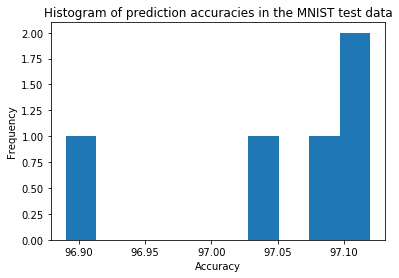

In [8]:
X_test = mnist.test.images
Y_test = np.argmax(mnist.test.labels,axis=1)

prediction_thetas = []

with tf.Session() as sess:
    for particle in theta_new:
        a = N_FEATURES*N_HIDDEN
        b = a + N_HIDDEN 
            
        pack_w1 = np.reshape(particle[:a], [N_FEATURES, N_HIDDEN])
        pack_b1 = particle[a:b]
            
        c = b + N_HIDDEN*N_CLASSES
        d = c + N_CLASSES 
            
        pack_w2 = np.reshape(particle[b:c], [N_HIDDEN, N_CLASSES])
        pack_b2 = particle[c:d]
            
        pack_log_lambda = particle[-1]

        prediction = sess.run(model_prediction, feed_dict= 
                              {model_x: X_test,
                               model_w1: pack_w1,
                               model_b1: pack_b1,
                               model_w2: pack_w2,
                               model_b2: pack_b2,
                               model_log_lambda: pack_log_lambda
        })
        prediction_thetas.append(prediction)

accy_test = []
for prediction_theta in prediction_thetas:
    y_trn_prd = np.argmax(prediction_theta,axis=1).astype(np.float32)
    acc = (y_trn_prd == Y_test).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")

(array([3., 0., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.00049018, 0.00049108, 0.00049197, 0.00049287, 0.00049377,
        0.00049467, 0.00049556, 0.00049646, 0.00049736, 0.00049825,
        0.00049915]),
 <a list of 10 Patch objects>)

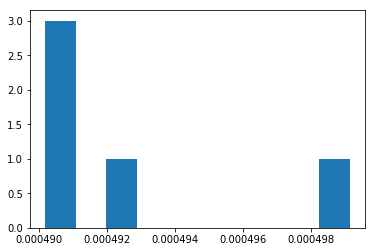

In [9]:
plt.hist(theta_new[:,0])

In [10]:
Y_pred = np.argmax(np.mean(prediction_thetas,axis=0),axis=1)
print("accuracy in predicting the test data = ", (Y_pred == Y_test).mean()*100)

('accuracy in predicting the test data = ', 97.17)


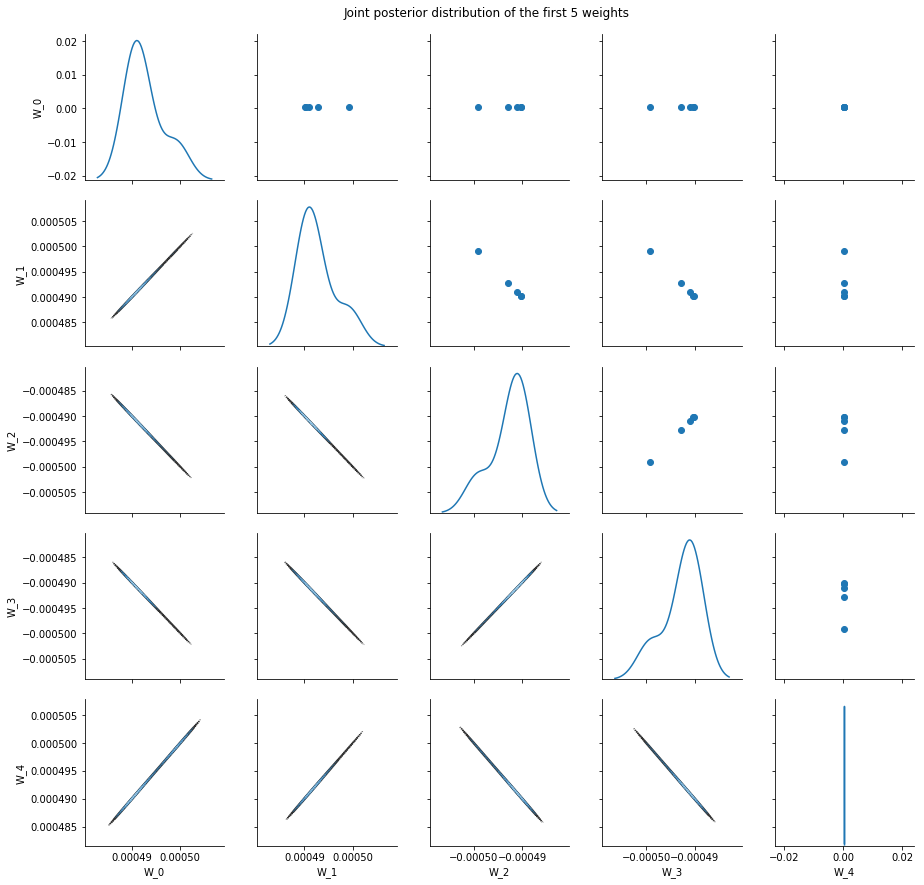

In [11]:
samples_df = pd.DataFrame(data = theta_new, index=range(M))
# Now create a small subset by taking the first 5 weights, labelled as W_0, ... , W_4.
samples_5 = pd.DataFrame(data = samples_df[list(range(5))].values,columns=["W_0", "W_1", "W_2", "W_3", "W_4"])
# We use Seaborn PairGrid to make a triale plot to show auto and cross correlations.
g = sns.PairGrid(samples_5, diag_sharey=False)
g.map_lower(sns.kdeplot, n_levels = 4,cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot,legend=False)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Joint posterior distribution of the first 5 weights')

In [12]:
m_grad_log_p

[<tf.Tensor 'model/gradients/AddN_9:0' shape=(784, 512) dtype=float32>,
 <tf.Tensor 'model/gradients/AddN_8:0' shape=(512,) dtype=float32>,
 <tf.Tensor 'model/gradients/AddN_7:0' shape=(512, 10) dtype=float32>,
 <tf.Tensor 'model/gradients/AddN_5:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'model/gradients/AddN_6:0' shape=() dtype=float32>]

In [13]:
a = np.array([[1,2,3],[4,5,6]])

In [14]:
a

array([[1, 2, 3],
       [4, 5, 6]])

In [15]:
a[:,-1]

array([3, 6])

In [16]:
a = [[1,2],[3,4],[5,6]]

In [17]:
np.argmax(np.mean(a, axis=0),axis=0)

1

In [18]:
model_fc1

<tf.Tensor 'model/prediction/Relu:0' shape=(?, 512) dtype=float32>